# Piqasso QuEra Challenge Submission

**QuEra iQuHack 2026 — Step 2**

This notebook implements:
1. **MSD State Encoding circuit** — Encode a state into the [[7,1,3]] (Steane/color) code, following QuEra's magic-state distillation work.
2. **Steane QEC** — One round of syndrome extraction: measure the six stabilizers of the [[7,1,3]] code and read out the syndrome.
3. **Noise analysis** — Parameter sweeps and fidelity comparison (no flags vs with flags).
4. **d=5 [[17,1,5]] encoding** — Scale to 17-qubit lattice; injection kernel and state analysis (from d5_piqasso_16_qubits.py).

References: [QuEra MSD (2412.15165)](https://arxiv.org/abs/2412.15165), [Steane QEC (2312.09745)](https://arxiv.org/pdf/2312.09745).

## 1. Setup

Install dependencies (run once; on Colab: **Runtime → Restart session** after). Then import Bloqade (Squin), Cirq interop, and Stim.

In [1]:
!pip install -q numpy cirq "bloqade-circuit[cirq,stim,tsim]>=0.11.0"
print("Done. On Colab: Runtime -> Restart session, then run the rest.")

Done. On Colab: Runtime -> Restart session, then run the rest.


  error: subprocess-exited-with-error
  
  × Building wheel for stim (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating python_build_stim\lib.win-amd64-cpython-313\stim
      copying glue\python\src\stim\_main_argv.py -> python_build_stim\lib.win-amd64-cpython-313\stim
      copying glue\python\src\stim\__init__.py -> python_build_stim\lib.win-amd64-cpython-313\stim
      running egg_info
      writing stim.egg-info\PKG-INFO
      writing dependency_links to stim.egg-info\dependency_links.txt
      writing entry points to stim.egg-info\entry_points.txt
      writing requirements to stim.egg-info\requires.txt
      writing top-level names to stim.egg-info\top_level.txt
      reading manifest file 'stim.egg-info\SOURCES.txt'
      reading manifest template 'MANIFEST.in'
      adding license file 'LICENSE'
      writing manifest file 'stim.egg-info\SOURCES.txt'
      cop

In [25]:
from typing import Literal
import numpy as np
from bloqade import squin
from bloqade.types import Qubit
from kirin.dialects import ilist
from math import pi
import bloqade.stim
import bloqade.tsim
from bloqade.cirq_utils import load_circuit
from bloqade.cirq_utils.emit import emit_circuit
from typing import List, Tuple, Optional


## 2. Magic State Preparation and Injection

Prepare the MSD circuit by introducing a magic state and injecting it into the 7 qubit code

In [3]:
@squin.kernel
def magicstateprep(qubits, ind):
    squin.t(qubits[ind])


def mapping_f(n):
    dicti = {0: 1, 1: 3, 2: 7, 3: 6, 4: 2, 5: 5, 6: 4}


@squin.kernel
def injection(q: ilist.IList[Qubit, Literal[7]]):
    """Apply magic-state injection to the 7-qubit register `q` (allocated by caller)."""
    squin.reset(q[0:2])
    squin.reset(q[2:7])
    magicstateprep(q, 2)
    # ry(-pi/2) on old 0..5  ->  new [3,1,0,6,4,5]
    for j in (3, 1, 0, 6, 4, 5):
        squin.ry(-pi / 2, q[j])

    # cz(1,2), cz(3,4), cz(5,6) -> cz(1,0), cz(6,4), cz(5,2)
    squin.cz(q[1], q[0])
    squin.cz(q[6], q[4])
    squin.cz(q[5], q[2])

    # ry on old 6 -> new 2
    squin.ry(pi / 2, q[2])

    # cz(0,3), cz(2,5), cz(4,6) -> cz(3,6), cz(0,5), cz(4,2)
    squin.cz(q[3], q[6])
    squin.cz(q[0], q[5])
    squin.cz(q[4], q[2])

    # ry on old 2..6 -> new [0,6,4,5,2]
    for j in (0, 6, 4, 5, 2):
        squin.ry(pi / 2, q[j])

    # cz(0,1), cz(2,3), cz(4,5) -> cz(3,1), cz(0,6), cz(4,5)
    squin.cz(q[3], q[1])
    squin.cz(q[0], q[6])
    squin.cz(q[4], q[5])

    # final single-qubit ry: old 1 -> 1, old 2 -> 0, old 4 -> 4
    squin.ry(pi / 2, q[1])
    squin.ry(pi / 2, q[0])
    squin.ry(pi / 2, q[4])
    squin.z(q[3])
    squin.x(q[0])
    squin.x(q[1])
    squin.x(q[3])


@squin.kernel
def main():
    """Wrapper: allocate 7 qubits and run injection (for emit_circuit without args)."""
    q = squin.qalloc(7)
    injection(q)

and let's look at what our circuit looks like

In [4]:
# Injection only (7 qubits) — use wrapper kernel since injection(q) takes a parameter
cirq_diagram = emit_circuit(main)
squin_for_diagram = load_circuit(cirq_diagram)
tsim_circ = bloqade.tsim.Circuit(squin_for_diagram)
fig = tsim_circ.diagram(height=400)
fig

### 2.1 Steane encoding and A3 circuit (from a3.ipynb)

This block adds the **Steane [[7,1,3]] encoding** (|0⟩_L and |+⟩_L) and the full **A3 circuit**: magic-state injection on 7 data qubits, then X-syndrome extraction (ancilla |+⟩_L), then Z-syndrome extraction (ancilla |0⟩_L), then measure all 14 ancillas.

In [5]:
# ---------------------------------------------------------------------------
# Steane [[7,1,3]] Encoding (a3.ipynb 119-140)
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_zero_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode |0⟩^7 → |0⟩_L on the 7-qubit register q (Steane [[7,1,3]])."""
    squin.h(q[0])
    squin.h(q[1])
    squin.h(q[3])
    squin.cx(q[0], q[4])
    squin.cx(q[1], q[2])
    squin.cx(q[3], q[5])
    squin.cx(q[0], q[6])
    squin.cx(q[3], q[4])
    squin.cx(q[1], q[5])
    squin.cx(q[0], q[2])
    squin.cx(q[5], q[6])


@squin.kernel
def steane_encode_plus_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode 7 qubits as |+⟩_L: first |0⟩_L then transversal H."""
    steane_encode_zero_on(q)
    for i in range(7):
        squin.h(q[i])


# ---------------------------------------------------------------------------
# A3 Circuit: Fault-tolerant Steane syndrome extraction (a3.ipynb 146-180)
# ---------------------------------------------------------------------------
@squin.kernel
def a3_circuit():
    """A3 circuit implementation in squin."""
    q = squin.qalloc(21)

    injection(q)
    # Qubits 0-6: logical data; Qubits 7-14 + 15-21: ancilla block

    # Prepare ancilla as |+⟩_L for first half (X-stabilizer syndrome)
    steane_encode_plus_on(q[7:14])

    # CNOTs: data → ancilla (X-syndrome extraction)
    for i in range(7):
        squin.cx(q[i], q[i + 7])

    # Prepare ancilla as |0⟩_L for second half (Z-stabilizer syndrome)
    steane_encode_zero_on(q[14:21])

    # CNOTs: ancilla → data (Z-syndrome extraction)
    for i in range(7):
        squin.cx(q[i + 14], q[i])

    # Transversal H on ancilla
    for i in range(7):
        squin.h(q[i + 14])

    # Measure ancilla qubits 7-21 (Syndrome bits)
    for i in range(7, 21):
        squin.measure(q[i])

### 2.2 Ancillas and syndrome-check helpers (from a3)

The A3 circuit measures **14 ancilla qubits** (two blocks of 7) to extract the **six stabilizer syndromes** of the Steane [[7,1,3]] code: three X-type and three Z-type. Each syndrome is a parity check over specific physical qubits.

- **`synd_dict`**: Maps stabilizer label → 1-based qubit indices for that stabilizer (Steane: [1,3,5,7], [4,5,6,7], [2,3,6,7]).
- **`to_parity`**: Converts measurement bits (0/1) to ±1 for parity product.
- **`find_syndrome`**: Returns whether one stabilizer is satisfied (product = +1) for a 7-bit block.
- **`findZSyndrome` / `findXSyndrome`**: Apply the check to the first 7 (Z-ancilla) or next 7 (X-ancilla) bits of a 14-bit sample.
- **`compute_syndromes`**: Returns (x_synds, z_synds)—three X and three Z syndrome bits per shot.
- **`find_good_rate`**: Fraction of shots where **all six** syndromes are satisfied (no detected error).

In [6]:
# Steane [[7,1,3]] stabilizer indices (1-based): which ancilla bits enter each parity check
synd_dict = {1: [1, 3, 5, 7], 2: [4, 5, 6, 7], 3: [2, 3, 6, 7]}


def to_parity(li):
    """Convert measurement bits to ±1 for parity product. False→+1, True→-1."""
    return [-2 * el + 1 for el in li]


def find_syndrome(li, idx):
    """Return True if the stabilizer (qubit indices idx, 1-based) is satisfied for 7-bit block li."""
    li = to_parity(li)
    mult = 1
    for ind in idx:
        mult *= li[ind - 1]
    return mult == 1


def findZSyndrome(sample, idx):
    """Z-syndrome from first 7 measurement bits (first ancilla block)."""
    return find_syndrome(sample[0:7], idx)


def findXSyndrome(sample, idx):
    """X-syndrome from next 7 measurement bits (second ancilla block)."""
    return find_syndrome(sample[7:14], idx)


def compute_syndromes(sample, ind_dict):
    """Return (x_synds, z_synds): each is a list of 3 booleans (one per stabilizer)."""
    x_synds, z_synds = [], []
    for key in list(ind_dict.keys()):
        idx = ind_dict[key]
        x_synds.append(findXSyndrome(sample, idx))
        z_synds.append(findZSyndrome(sample, idx))
    return x_synds, z_synds


def find_good_rate(samples, ind_dict, verbose=False):
    """Fraction of shots with all 6 syndromes satisfied (no detected error). Matches a3.ipynb."""
    good_samples = 0
    for j, sample in enumerate(samples):
        synd = compute_syndromes(sample, ind_dict)
        if verbose:
            print(j, synd)
        if np.count_nonzero(synd) == 6:
            good_samples += 1
    return good_samples / len(samples) if len(samples) else 0.0

### 2.3 Sanity Checking

**What we are searching for**

1. **Logical consistency**: For the ideal (noiseless) A3 circuit, every shot should have **all six stabilizer syndromes satisfied**. That means: for each shot, the 14 ancilla measurement bits are split into two blocks of 7; we compute 3 X-syndromes and 3 Z-syndromes via parity checks. We expect **all 6 to be True** (product +1) when there is no error.
2. **Fidelity (good rate)**: The fraction of shots with all 6 syndromes satisfied. For a correct, noiseless implementation we expect **fidelity ≈ 1.0**.
3. **Syndrome distribution**: How many shots have 0, 1, …, 6 syndromes satisfied. We expect almost all shots at 6 when there is no noise.
4. **Raw vs syndrome-based**: Raw measurement error rate (fraction of bits that are 1) can be nonzero; the **syndrome-good rate** is the meaningful check that the logical state is correct. 

In [7]:
# Steane encoding and a3_circuit are defined in section 2.2 (Part 2).
# Below: a3extraction and executiona3 only.


@squin.kernel
def a3extraction(data: ilist.IList[Qubit, Literal[7]], ancilla: ilist.IList[Qubit, Literal[7]]):
    """Full fault-tolerant Steane EC cycle: 14 qubits (7 data + 7 ancilla). First half: ancilla |+⟩_L, CNOT data→ancilla, measure (X-syndrome), reset. Second half: ancilla |0⟩_L, CNOT ancilla→data, H on ancilla, measure (Z-syndrome)."""
    steane_encode_plus_on(ancilla)
    for i in range(7):
        squin.cx(data[i], ancilla[i])
    squin.broadcast.measure(ancilla)
    squin.broadcast.reset(ancilla)
    steane_encode_zero_on(ancilla)
    for i in range(7):
        squin.cx(ancilla[i], data[i])
    for i in range(7):
        squin.h(ancilla[i])
    squin.broadcast.measure(ancilla)


@squin.kernel
def executiona3():
    """Sequential: (1) inject magic state into 7 data qubits; (2) run a3 extraction on that data + 7 ancillas."""
    q = squin.qalloc(7)
    injection(q)
    ancilla = squin.qalloc(7)
    a3extraction(q, ancilla)

Before we proceed any further, let's check to make sure that our syndrome extraction is valid. We do not introduce any noise into our system so we should have full fidelity.

In [12]:
# a3_circuit is defined in section 2.2 (Part 2). Run cells in order so it is available here.

### 2.4 Graphing

**What we are searching for**

1. **Logical consistency**: For the ideal (noiseless) A3 circuit, every shot should have **all six stabilizer syndromes satisfied**. That means:
   - For each shot, the 14 ancilla measurement bits are split into two blocks of 7; we compute 3 X-syndromes and 3 Z-syndromes via parity checks. We expect **all 6 to be True** (product +1) when there is no error.
2. **Fidelity (good rate)**: The fraction of shots with all 6 syndromes satisfied. For a correct, noiseless implementation we expect **fidelity ≈ 1.0**.
3. **Syndrome distribution**: How many shots have 0, 1, …, 6 syndromes satisfied. We expect almost all shots at 6 when there is no noise.
4. **Raw vs syndrome-based**: Raw measurement error rate (fraction of bits that are 1) can be nonzero due to the magic state; the **syndrome-good rate** is the meaningful check that the logical state is correct.

In [8]:
cirq_enc = emit_circuit(a3_circuit)
squin_enc = load_circuit(cirq_enc)
stim_enc = bloqade.stim.Circuit(squin_enc)
fig = stim_enc.diagram()
sampler = stim_enc.compile_sampler()
samples_enc = np.array(sampler.sample(shots=10))

print("MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)")
print("Sample shape:", samples_enc.shape)
print("First 5 shots:\n", samples_enc[:5])
print(np.count_nonzero(samples_enc)/len(samples_enc))
fig

MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)
Sample shape: (10, 14)
First 5 shots:
 [[False  True  True False False  True  True  True False  True  True False
   True False]
 [ True False False False False  True  True False  True False False  True
  False  True]
 [ True  True  True False False False False False  True False False  True
  False  True]
 [ True  True False  True False False  True  True False False  True  True
  False False]
 [False False False  True  True  True  True False False  True False  True
   True False]]
7.7


q0: -R-SQRT_Y_DAG---@----------------@-SQRT_Y---------------@-SQRT_Y-----X----------------@---------X----------------------------
                     |                |                      |                             |         |
 q1: -R-SQRT_Y_DAG---@----------------|--------@-------------|-SQRT_Y-X----------@---------|---X-----|----------------------------
                                      |        |             |                   |         |   |     |
 q2: -R-S--------------@-------SQRT_Y-|-@------|------SQRT_Y-|----------@--------|-----X---|---|-----|----------------------------
                       |              | |      |             |          |        |     |   |   |     |
 q3: -R-SQRT_Y_DAG-----|-------@------|-|------@-------------|-Z------X-|--------|-@---|---|---|-X---|----------------------------
                       |       |      | |                    |          |        | |   |   |   | |   |
 q4: -R-SQRT_Y_DAG---@-|-------|------|-@------SQRT_Y--------|-@--------|-SQRT_Y-|-|---|---|-@-|-|---|-X--------------------------
                     | |       |      |                      | |        |        | |   |   | | | |   | |
 q5: -R-SQRT_Y_DAG---|-@-------|------@-SQRT_Y---------------|-@--------|--------|-|-@-|---|-|-|-|-X-|-|--------------------------
                     |         |                             |          |        | | | |   | | | | | | |
 q6: -R-SQRT_Y_DAG---@---------@--------SQRT_Y---------------@----------|-@------|-|-|-|-X-|-|-|-|-|-|-|--------------------------
                                                                        | |      | | | | | | | | | | | |
 q7: -H-@--------------@--------------@--------H------------------------|-|------|-|-|-|-|-X-|-|-|-|-|-|-M(0):rec[0]--------------
        |              |              |                                 | |      | | | | |   | | | | | |
 q8: -H-|----------@---|---@----------|-H-------------------------------|-|------X-|-|-|-|---|-|-|-|-|-|-M(0):rec[1]--------------
        |          |   |   |          |                                 | |        | | | |   | | | | | |
 q9: ---|----------X---|---|----------X--------H------------------------X-|--------|-|-|-|---|-|-|-|-|-|-M(0):rec[2]--------------
        |              |   |                                              |        | | | |   | | | | | |
q10: -H-|----------@---|-@-|------------H---------------------------------|--------X-|-|-|---|-|-|-|-|-|-M(0):rec[3]--------------
        |          |   | | |                                              |          | | |   | | | | | |
q11: ---X----------|---|-X-|------------H---------------------------------|----------|-|-|---X-|-|-|-|-|-M(0):rec[4]--------------
                   |   |   |                                              |          | | |     | | | | |
q12: --------------X---|---X----------@--------H--------------------------|----------X-|-|-----|-|-|-|-|-M(0):rec[5]--------------
                       |              |                                   |            | |     | | | | |
q13: ------------------X--------------X--------H--------------------------X------------|-|-----|-|-|-|-|-M(0):rec[6]--------------
                                                                                       | |     | | | | |
q14: -H------------@-------@------------@----------------------------------------------|-|-----|-|-|-@-|-H-----------M(0):rec[7]--
                   |       |            |                                              | |     | | |   |
q15: -H------------|-@-----|---@--------|----------------------------------------------|-|-----@-|-|---|-H-----------M(0):rec[8]--
                   | |     |   |        |                                              | |       | |   |
q16: --------------|-X-----|---|--------X----------------------------------------------@-|-------|-|-H-|-------------M(0):rec[9]--
                   |       |   |                                                         |       | |  

In [9]:
# Run A3 with more shots for sanity checks and fidelity stats (helpers from section 2.4)
import matplotlib.pyplot as plt

SANITY_SHOTS = 1000
cirq_enc_sc = emit_circuit(a3_circuit)
squin_enc_sc = load_circuit(cirq_enc_sc)
stim_enc_sc = bloqade.stim.Circuit(squin_enc_sc)
sampler_sc = stim_enc_sc.compile_sampler()
samples_sanity = np.array(sampler_sc.sample(shots=SANITY_SHOTS))

good_rate = find_good_rate(samples_sanity, synd_dict, verbose=False)

def _n_satisfied(s, ind_dict):
    xs, zs = compute_syndromes(s, ind_dict)
    return np.sum(xs) + np.sum(zs)

n_satisfied_per_shot = [_n_satisfied(s, synd_dict) for s in samples_sanity]
raw_error_rate = np.count_nonzero(samples_sanity) / samples_sanity.size

print("What we are checking: all 6 syndromes satisfied = no detected error.")
print(f"Shots: {SANITY_SHOTS}  |  Fidelity (good rate): {good_rate:.4f}  |  Raw bit error rate: {raw_error_rate:.4f}")
print(f"Good shots (all 6 satisfied): {sum(1 for n in n_satisfied_per_shot if n == 6)}")

What we are checking: all 6 syndromes satisfied = no detected error.
Shots: 1000  |  Fidelity (good rate): 1.0000  |  Raw bit error rate: 0.5034
Good shots (all 6 satisfied): 1000


In [10]:
# ---------------------------------------------------------------------------
# Plotting methods (distilled from 2.5, 2.6.1.5, 2.6.2)
# ---------------------------------------------------------------------------
import matplotlib.pyplot as plt

def plot_fidelity_bar(good_rate, title="Fidelity (good rate)", ylabel="Fraction of shots with all 6 syndromes satisfied", bar_label="Fidelity\n(good rate)", figsize=(4, 3)):
    """Single bar: fidelity (good rate)."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.bar([bar_label], [good_rate], color="steelblue", edgecolor="black")
    ax.set_ylim(0, 1.05)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_syndrome_distribution(n_satisfied_per_shot, title="Syndrome distribution (0-6 satisfied)", figsize=(6, 3)):
    """Histogram: number of shots with 0, 1, ..., 6 syndromes satisfied."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    counts, _ = np.histogram(n_satisfied_per_shot, bins=np.arange(8) - 0.5)
    ax.bar(range(7), counts, color="teal", edgecolor="black")
    ax.set_xticks(range(7))
    ax.set_xlabel("Number of syndromes satisfied (out of 6)")
    ax.set_ylabel("Number of shots")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_fidelity_vs_shots(shot_counts, fidelities, title="Fidelity vs shot count (stability check)", figsize=(5, 3)):
    """Line plot: fidelity (good rate) vs number of shots."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(shot_counts, fidelities, "o-", color="darkgreen")
    ax.set_xlabel("Number of shots")
    ax.set_ylabel("Fidelity (good rate)")
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_kept_vs_discarded(n_kept, n_total, title="Kept vs discarded", kept_label="Kept", discarded_label="Discarded", figsize=(5, 3)):
    """Two bars: fraction kept and fraction discarded (e.g. flag behavior)."""
    frac_kept = n_kept / n_total
    frac_discarded = 1.0 - frac_kept
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.bar([kept_label, discarded_label], [frac_kept, frac_discarded], color=["steelblue", "coral"], edgecolor="black")
    ax.set_ylabel("Fraction of shots")
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_flag_outcome_binary(n_kept, n_discarded, title="Flag outcome distribution", figsize=(5, 3)):
    """Two bars: counts for flag=0 (keep) and flag=1 (discard)."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.bar([0, 1], [n_kept, n_discarded], color=["green", "red"], edgecolor="black")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Flag=0 (keep)", "Flag=1 (discard)"])
    ax.set_ylabel("Number of shots")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_flag_trigger_distribution(n_flags_triggered_per_shot, max_val=2, title="Flag trigger distribution (0 = keep, 1 or 2 = discard)", figsize=(5, 3)):
    """Histogram: number of shots with 0, 1, ..., max_val flags triggered."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    counts, _ = np.histogram(n_flags_triggered_per_shot, bins=np.arange(max_val + 2) - 0.5)
    colors = ["green", "orange", "red"][: max_val + 1]
    ax.bar(range(max_val + 1), counts, color=colors, edgecolor="black")
    ax.set_xticks(range(max_val + 1))
    ax.set_xlabel("Number of flags triggered")
    ax.set_ylabel("Number of shots")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


Now let us render the graphs. We plot: (1) **Fidelity** — fraction of shots with all 6 syndromes satisfied; (2) **Syndrome distribution** — how many shots have 0, 1, …, 6 syndromes satisfied (we expect almost all at 6 for noiseless); (3) **Fidelity vs number of shots** — good rate over increasing shot counts (stability).

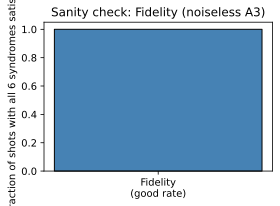

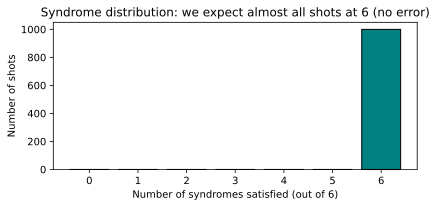

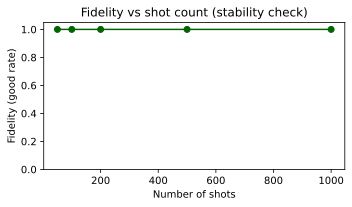

In [11]:
# Use plotting methods (defined in section 2.5)
shot_sweep = [50, 100, 200, 500, min(1000, len(samples_sanity))]
shot_sweep = [n for n in shot_sweep if n <= len(samples_sanity)]
fidelities_vs_shots = [find_good_rate(samples_sanity[:n], synd_dict, verbose=False) for n in shot_sweep]

plot_fidelity_bar(good_rate, title="Sanity check: Fidelity (noiseless A3)")
plot_syndrome_distribution(n_satisfied_per_shot, title="Syndrome distribution: we expect almost all shots at 6 (no error)")
plot_fidelity_vs_shots(shot_sweep, fidelities_vs_shots, title="Fidelity vs shot count (stability check)")

The printed fidelity (good rate) and the graphs above confirm that the checking algorithm is valid: we expect fidelity ≈ 1.0 and almost all shots at 6 satisfied syndromes when the circuit is noiseless.

### 2.6 Flag qubits

We use **one flag qubit per Steane encode**, and we **latch before the encode** so the flag is triggered only when something goes wrong. The ancilla start in |0⟩^7; we apply **CX** from the **third, fifth, and sixth ancilla qubits** (indices 2, 4, 5) to the flag **before** running the Steane encode. In the ideal case all three are |0⟩, so the flag stays 0. Then we run `steane_encode_zero_on` or `steane_encode_plus_on`. The flag triggers (1) only if one of those qubits was wrong before the encode (e.g. preparation error).

In [12]:
# ---------------------------------------------------------------------------
# Steane encode zero with one flag qubit (3rd, 5th, 6th ancilla → single flag)
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_zero_on_with_flags(q: ilist.IList[Qubit, Literal[7]], flag: Qubit):
    """Encode |0⟩^7 → |0⟩_L on q (Steane [[7,1,3]]), then CX from 3rd, 5th, 6th ancilla to one flag."""
    steane_encode_zero_on(q)
    squin.cx(q[2], flag)
    squin.cx(q[4], flag)
    squin.cx(q[5], flag)


# ---------------------------------------------------------------------------
# Steane encode plus with one flag qubit (3rd, 5th, 6th ancilla → single flag)
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_plus_on_with_flags(q: ilist.IList[Qubit, Literal[7]], flag: Qubit):
    """Encode |+⟩_L on q (Steane [[7,1,3]]), then CX from 3rd, 5th, 6th ancilla to one flag."""
    squin.h(q[0])
    squin.h(q[1])
    squin.h(q[3])
    squin.cx(q[0], q[4])
    squin.cx(q[1], q[2])
    squin.cx(q[3], q[5])
    squin.cx(q[0], q[6])
    squin.cx(q[3], q[4])
    squin.cx(q[1], q[5])
    squin.cx(q[0], q[2])
    squin.cx(q[5], q[6])

    squin.cx(q[2], flag)
    squin.cx(q[4], flag)
    squin.cx(q[5], flag)

    for i in range(7):
        squin.h(q[i])

In [13]:
# ---------------------------------------------------------------------------
# A3-style circuit with flags (one flag per encode: plus for X-block, zero for Z-block)
# ---------------------------------------------------------------------------
@squin.kernel
def a3_circuit_with_flags():
    """A3 circuit with flags: 23 qubits (7 data + 7 X-ancilla + 7 Z-ancilla + 2 flags)."""
    q = squin.qalloc(23)
    # Qubits 0-6: data; 7-13: X-ancilla; 14-20: Z-ancilla; 21: flag X; 22: flag Z

    injection(q[0:7])

    # X-syndrome: ancilla |+⟩_L with flag, CNOT data → ancilla
    steane_encode_plus_on_with_flags(q[7:14], q[21])
    for i in range(7):
        squin.cx(q[i], q[i + 7])

    # Z-syndrome: ancilla |0⟩_L with flag (3rd, 5th, 6th Z-ancilla → one flag)
    steane_encode_zero_on_with_flags(q[14:21], q[22])

    # CNOTs: Z-ancilla → data
    for i in range(7):
        squin.cx(q[i + 14], q[i])

    # Transversal H on Z-ancilla
    for i in range(7):
        squin.h(q[i + 14])

    # Measure all syndrome bits (14) and flag bits (2)
    for i in range(7, 23):
        squin.measure(q[i])


@squin.kernel
def executionflaga3():
    """Sequential: run A3 circuit with flags (23 qubits: 7 data + 7 X-ancilla + 7 Z-ancilla + 2 flags). Same role as executiona3 but with flagged encodes."""
    a3_circuit_with_flags()

#### 2.6.1 Circuit with flags

The **A3-style circuit with flags** uses **one flag per encode**: the X-ancilla block uses `steane_encode_plus_on_with_flags` (one flag), and the Z-ancilla block uses `steane_encode_zero_on_with_flags` (one flag). We allocate **23 qubits**: 7 data, 7 X-ancilla, 7 Z-ancilla, 2 flags. At the end we measure all 14 syndrome bits plus the 2 flag bits (16 measurements).

In [14]:
# Emit executionflaga3 (23 qubits with flags) and display diagram (same pattern as executiona3 plot)
cirq_flaga3 = emit_circuit(executionflaga3)
squin_flaga3 = load_circuit(cirq_flaga3)
tsim_flaga3 = bloqade.tsim.Circuit(squin_flaga3)
fig_flaga3 = tsim_flaga3.diagram(height=500)
fig_flaga3

#### 2.6.1.5 One unit: steane_encode_zero_on_with_flags

We run a **single** Steane encode with one flag: 7 ancilla qubits plus 1 flag (8 qubits total). We prepare |0⟩_L on the ancilla block with the flag latching before the encode, then measure all 8 qubits. This isolates the flag behavior for the Z-encode unit. Below we build the circuit, display its diagram, run it, and plot **kept vs. not kept** (and related graphs) using the same evaluation rule: keep a shot only when the flag is 0.

In [15]:
# One unit: 7 ancilla + 1 flag; run steane_encode_zero_on_with_flags, then measure all 8
@squin.kernel
def one_unit_zero_with_flags():
    q = squin.qalloc(8)
    steane_encode_zero_on_with_flags(q[0:7], q[7])
    for i in range(8):
        squin.measure(q[i])

# Emit and display diagram
cirq_one_unit = emit_circuit(one_unit_zero_with_flags)
squin_one_unit = load_circuit(cirq_one_unit)
tsim_one_unit = bloqade.tsim.Circuit(squin_one_unit)
fig_one_unit = tsim_one_unit.diagram(height=400)
fig_one_unit

2.6.1.5 One unit (steane_encode_zero_on_with_flags):
Shots: 1000  |  Kept: 1000  |  Discarded: 0  |  Discard rate: 0.0000


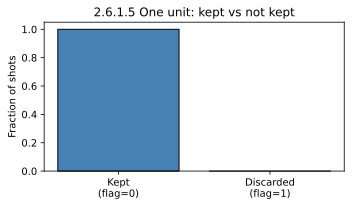

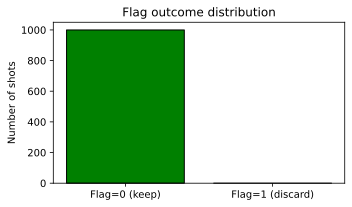

In [16]:
# Run one-unit circuit and evaluate flag: keep when flag == 0
UNIT_SHOTS = 1000
cirq_one_unit_run = emit_circuit(one_unit_zero_with_flags)
squin_one_unit_run = load_circuit(cirq_one_unit_run)
stim_one_unit = bloqade.stim.Circuit(squin_one_unit_run)
sampler_one_unit = stim_one_unit.compile_sampler()
samples_one_unit = np.array(sampler_one_unit.sample(shots=UNIT_SHOTS))

# Sample layout: 8 columns — 0–6 = ancilla measurements, 7 = flag
flag_col = samples_one_unit[:, 7]
kept_mask_unit = (flag_col == 0)
n_kept_unit = np.sum(kept_mask_unit)
n_discarded_unit = UNIT_SHOTS - n_kept_unit
discard_rate_unit = n_discarded_unit / UNIT_SHOTS

print("2.6.1.5 One unit (steane_encode_zero_on_with_flags):")
print(f"Shots: {UNIT_SHOTS}  |  Kept: {n_kept_unit}  |  Discarded: {n_discarded_unit}  |  Discard rate: {discard_rate_unit:.4f}")

# Graphs: kept vs not kept, and flag outcome distribution
plot_kept_vs_discarded(n_kept_unit, UNIT_SHOTS, title="2.6.1.5 One unit: kept vs not kept", kept_label="Kept\n(flag=0)", discarded_label="Discarded\n(flag=1)")
plot_flag_outcome_binary(n_kept_unit, n_discarded_unit, title="Flag outcome distribution")

#### 2.6.1.6 One unit: steane_encode_plus_on_with_flags

We run a **single** Steane encode with one flag for the **plus** (|+⟩_L) unit: 7 ancilla qubits plus 1 flag (8 qubits total). We prepare |+⟩_L on the ancilla block with the flag, then measure all 8 qubits. Below we build the circuit, display its diagram, run it, and plot **kept vs. not kept** and flag outcome distribution (same evaluation rule: keep a shot only when the flag is 0).

In [17]:
# One unit (plus): 7 ancilla + 1 flag; run steane_encode_plus_on_with_flags, then measure all 8
@squin.kernel
def one_unit_plus_with_flags():
    q = squin.qalloc(8)
    steane_encode_plus_on_with_flags(q[0:7], q[7])
    for i in range(8):
        squin.measure(q[i])

# Emit and display diagram
cirq_one_unit_plus = emit_circuit(one_unit_plus_with_flags)
squin_one_unit_plus = load_circuit(cirq_one_unit_plus)
tsim_one_unit_plus = bloqade.tsim.Circuit(squin_one_unit_plus)
fig_one_unit_plus = tsim_one_unit_plus.diagram(height=400)
fig_one_unit_plus

2.6.1.6 One unit (steane_encode_plus_on_with_flags):
Shots: 1000  |  Kept: 1000  |  Discarded: 0  |  Discard rate: 0.0000


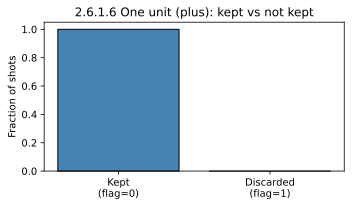

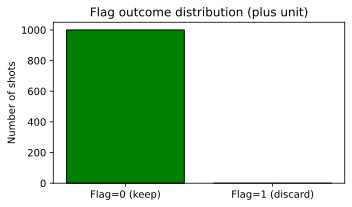

In [17]:
# Run one-unit plus circuit and evaluate flag: keep when flag == 0
UNIT_SHOTS_PLUS = 1000
cirq_one_unit_plus_run = emit_circuit(one_unit_plus_with_flags)
squin_one_unit_plus_run = load_circuit(cirq_one_unit_plus_run)
stim_one_unit_plus = bloqade.stim.Circuit(squin_one_unit_plus_run)
sampler_one_unit_plus = stim_one_unit_plus.compile_sampler()
samples_one_unit_plus = np.array(sampler_one_unit_plus.sample(shots=UNIT_SHOTS_PLUS))

# Sample layout: 8 columns — 0–6 = ancilla measurements, 7 = flag
flag_col_plus = samples_one_unit_plus[:, 7]
kept_mask_unit_plus = (flag_col_plus == 0)
n_kept_unit_plus = np.sum(kept_mask_unit_plus)
n_discarded_unit_plus = UNIT_SHOTS_PLUS - n_kept_unit_plus
discard_rate_unit_plus = n_discarded_unit_plus / UNIT_SHOTS_PLUS

print("2.6.1.6 One unit (steane_encode_plus_on_with_flags):")
print(f"Shots: {UNIT_SHOTS_PLUS}  |  Kept: {n_kept_unit_plus}  |  Discarded: {n_discarded_unit_plus}  |  Discard rate: {discard_rate_unit_plus:.4f}")

# Graphs: kept vs not kept, and flag outcome distribution
plot_kept_vs_discarded(n_kept_unit_plus, UNIT_SHOTS_PLUS, title="2.6.1.6 One unit (plus): kept vs not kept", kept_label="Kept\n(flag=0)", discarded_label="Discarded\n(flag=1)")
plot_flag_outcome_binary(n_kept_unit_plus, n_discarded_unit_plus, title="Flag outcome distribution (plus unit)")

#### 2.6.2 Flag behavior and graphs (four ancilla flag qubits)

**Flag behavior**: We use the **A4 circuit** (executiona4) with **four ancilla flag qubits** (ancilla[1], [2], [4], [5]). We **discard** a shot if any flag qubit is triggered (measured as 1), and **keep** only shots where all four flag bits are 0. This implements the standard flagged-syndrome behavior.

Below we run the A4 circuit, apply this discard rule, and for **each of the four flag qubits** we plot **two graphs**: (1) **Kept vs discarded** (fraction of shots with that flag = 0 vs 1), (2) **Flag outcome distribution** (counts for keep vs discard). We also show overall **kept vs discarded** and **flag trigger distribution** (0–4 flags triggered).

In [ ]:
# Run A3 circuit with flags and collect samples (16 measurements: 14 syndrome + 2 flags)
FLAG_SHOTS = 1000
cirq_flaga3_run = emit_circuit(a3_circuit_with_flags)
squin_flaga3_run = load_circuit(cirq_flaga3_run)
stim_flaga3 = bloqade.stim.Circuit(squin_flaga3_run)
sampler_flaga3 = stim_flaga3.compile_sampler()
samples_flags = np.array(sampler_flaga3.sample(shots=FLAG_SHOTS))

# Flag behavior: discard shot if any flag is triggered (flag bit == 1)
# Sample layout: columns 0-13 = syndrome bits, 14 = flag X, 15 = flag Z (measure order q7..q22)
# Use (flag == 0) not ~flag: samples are 0/1 ints, so ~0 is not boolean False and kept_mask would be wrong.
flag_x = samples_flags[:, 14]
flag_z = samples_flags[:, 15]
kept_mask = (flag_x == 0) & (flag_z == 0)  # keep only when both flags are 0 (ideal: all kept)
n_kept = np.sum(kept_mask)
n_discarded = FLAG_SHOTS - n_kept
discard_rate = n_discarded / FLAG_SHOTS

# Fidelity (good rate) among kept shots only (syndrome bits = first 14 columns)
samples_kept_syndrome = samples_flags[kept_mask][:, 0:14]
good_rate_kept = find_good_rate(samples_kept_syndrome, synd_dict, verbose=False) if n_kept > 0 else 0.0

# Number of flags triggered per shot (0, 1, or 2)
n_flags_triggered = np.sum(samples_flags[:, 14:16], axis=1)

print("Flag behavior: discard shot if any flag is triggered (measurement = 1).")
print(f"Shots: {FLAG_SHOTS}  |  Kept: {n_kept}  |  Discarded: {n_discarded}  |  Discard rate: {discard_rate:.4f}")
print(f"Fidelity among kept shots: {good_rate_kept:.4f}")


Flag behavior: discard shot if any flag is triggered (measurement = 1).
Shots: 1000  |  Kept: 1000  |  Discarded: 0  |  Discard rate: 0.0000
Fidelity among kept shots: 1.0000


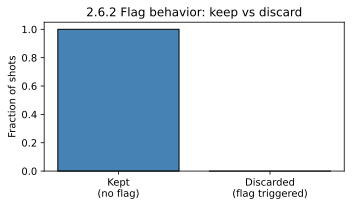

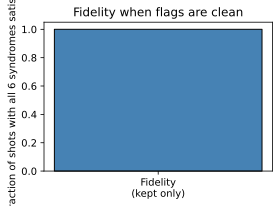

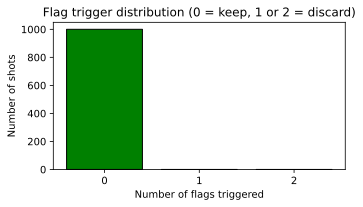

In [19]:
# Use plotting methods (defined in section 2.5)
plot_kept_vs_discarded(n_kept, FLAG_SHOTS, title="2.6.2 Flag behavior: keep vs discard", kept_label="Kept\n(no flag)", discarded_label="Discarded\n(flag triggered)")
plot_fidelity_bar(good_rate_kept, title="Fidelity when flags are clean", bar_label="Fidelity\n(kept only)")
plot_flag_trigger_distribution(n_flags_triggered, max_val=2, title="Flag trigger distribution (0 = keep, 1 or 2 = discard)")

## 3. Noise Testing (from noisetesting.py)

This section implements **comprehensive noise analysis** for the A3 circuit, following the structure and tests in `noisetesting.py`. We use Bloqade’s **GeminiOneZoneNoiseModel** to inject realistic noise and study how **fidelity** (fraction of shots with all six syndromes satisfied) degrades.

**What we implement:**
1. **With-flags vs without-flags**: We run the same noise tests on **two** circuits — the standard **A3 circuit** (21 qubits, 14 syndrome measurements) and the **A3 circuit with flags** (23 qubits, 14 syndrome + 2 flag measurements). For the flagged circuit, we **discard** shots where any flag is triggered (flag = 1) and compute fidelity only over **kept** shots (flag = 0), matching the behavior in Section 2.6.
2. **Scaling coefficient analysis**: We sweep a **scaling factor** applied to the full GeminiOneZoneNoiseModel (as in `noisetesting.py`) and record fidelity for each value, for both circuits.
3. **All 15 parameter sweeps**: We iterate over each of the **15 parameters** of GeminiOneZoneNoiseModel (global_px/py/pz, local_*, local_unaddressed_*, cz_paired_gate_*, cz_unpaired_gate_*) and sweep each parameter from 0 to a max value (2e-3 for non-gate, 5e-2 for gate params), with all other params set to zero.
4. **Comparison plots**: We plot fidelity vs scaling and fidelity vs parameter for **both** circuits on the same axes, and add summary plots that compare **with-flags vs without-flags** (e.g. fidelity difference, or overlaid curves).

All tests use the same **syndrome-based fidelity** definition: a shot is “good” if all six Steane stabilizer syndromes are satisfied (computed via `find_good_rate` and `synd_dict` from Section 2.2).

### 3.1 Imports and simulation helpers

We import **noise** from `bloqade.cirq_utils` (used to apply **GeminiOneZoneNoiseModel** to the emitted Cirq circuit) and **scipy.optimize.curve_fit** for fitting fidelity decay curves. We define:

- **`run_simulation_no_flags(noise_model, shots)`**: Emit `a3_circuit()`, apply the noise model via `noise.transform_circuit`, load into Stim, sample, and return **fidelity** (good rate over all shots using `find_good_rate(samples, synd_dict)`). Sample layout: 14 columns (syndrome bits only).
- **`run_simulation_with_flags(noise_model, shots)`**: Emit `a3_circuit_with_flags()`, apply noise, sample (16 columns: 14 syndrome + 2 flags). We **keep** only shots where both flag bits are 0 (columns 14 and 15). Fidelity is computed as **good rate among kept shots** (using the first 14 columns of kept samples). If no shots are kept, we return 0.0.

We also define the **list of 15 GeminiOneZoneNoiseModel parameter names** used in noisetesting.py for the parameter sweeps.

In [70]:
# Section 3: Noise testing (from noisetesting.py)
from bloqade.cirq_utils import noise
from scipy.optimize import curve_fit

# 15 parameters of GeminiOneZoneNoiseModel (same as noisetesting.py)
NOISE_PARAMS = [
    'global_px', 'global_py', 'global_pz',
    'local_px', 'local_py', 'local_pz',
    'local_unaddressed_px', 'local_unaddressed_py', 'local_unaddressed_pz',
    'cz_paired_gate_px', 'cz_paired_gate_py', 'cz_paired_gate_pz',
    'cz_unpaired_gate_px', 'cz_unpaired_gate_py', 'cz_unpaired_gate_pz',
]

def run_simulation_no_flags(noise_model, shots=500):
    """Run A3 circuit (no flags) with noise; return fidelity (good rate over all shots)."""
    cirq_circuit = emit_circuit(a3_circuit)
    cirq_noisy = noise.transform_circuit(cirq_circuit, model=noise_model)
    squin_circuit = load_circuit(cirq_noisy)
    stim_circuit = bloqade.stim.Circuit(squin_circuit)
    samples = np.array(stim_circuit.compile_sampler().sample(shots=shots))
    return find_good_rate(samples, synd_dict, verbose=False)

def run_simulation_with_flags(noise_model, shots=500):
    """Run A3 circuit with flags; keep only shots where both flags are 0; return fidelity among kept shots."""
    cirq_circuit = emit_circuit(a3_circuit_with_flags)
    cirq_noisy = noise.transform_circuit(cirq_circuit, model=noise_model)
    squin_circuit = load_circuit(cirq_noisy)
    stim_circuit = bloqade.stim.Circuit(squin_circuit)
    samples = np.array(stim_circuit.compile_sampler().sample(shots=shots))
    # Columns 0-13 = syndrome, 14 = flag X, 15 = flag Z
    flag_x = samples[:, 14]
    flag_z = samples[:, 15]
    kept_mask = (flag_x == 0) & (flag_z == 0)
    n_kept = np.sum(kept_mask)
    if n_kept == 0:
        return 0.0
    samples_kept = samples[kept_mask][:, 0:14]
    return find_good_rate(samples_kept, synd_dict, verbose=False)

### 3.2 Scaling coefficient analysis (GeminiOneZoneNoiseModel)

We sweep the **scaling factor** of `GeminiOneZoneNoiseModel(scaling_factor=c)` over a range (e.g. 0.1 to 3.0, as in noisetesting.py). For each value of `c` we run:

1. **No flags**: `run_simulation_no_flags(noise.GeminiOneZoneNoiseModel(scaling_factor=c), shots=SHOTS)` → fidelity over all shots.
2. **With flags**: `run_simulation_with_flags(...)` → fidelity over **kept** shots only.

We store `coeffs`, `fidelities_no_flags`, and `fidelities_with_flags`. Then we plot **fidelity vs scaling coefficient** for both circuits on the same axes (with optional curve fits: exponential decay, power law, logarithmic, as in noisetesting.py).

In [71]:
# Configuration (match noisetesting.py; reduce points slightly for notebook runtime)
SCALING_COEFFS = np.linspace(0.1, 3.0, 20)
SHOTS_PER_TEST = 500  # shots per noise configuration

# Run scaling analysis: no flags and with flags
fidelities_no_flags = []
fidelities_with_flags = []
for i, c in enumerate(SCALING_COEFFS):
    noise_model = noise.GeminiOneZoneNoiseModel(scaling_factor=float(c))
    f_no = run_simulation_no_flags(noise_model, shots=SHOTS_PER_TEST)
    f_fl = run_simulation_with_flags(noise_model, shots=SHOTS_PER_TEST)
    fidelities_no_flags.append(f_no)
    fidelities_with_flags.append(f_fl)
    if (i + 1) % 5 == 0:
        print(f"  Scaling {i+1}/{len(SCALING_COEFFS)}: c={c:.2f}  no_flags={f_no:.4f}  with_flags={f_fl:.4f}")

coeffs = np.array(SCALING_COEFFS)
fidelities_no_flags = np.array(fidelities_no_flags)
fidelities_with_flags = np.array(fidelities_with_flags)

  Scaling 5/20: c=0.71  no_flags=0.4600  with_flags=0.4209
  Scaling 10/20: c=1.47  no_flags=0.1940  with_flags=0.1927
  Scaling 15/20: c=2.24  no_flags=0.1160  with_flags=0.0662
  Scaling 20/20: c=3.00  no_flags=0.0400  with_flags=0.0569


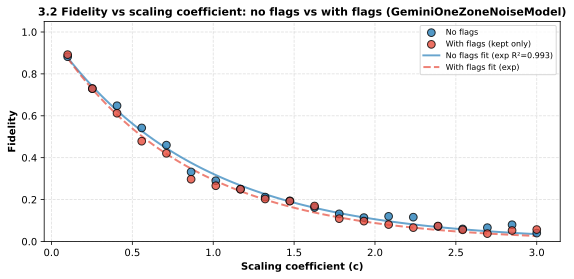

In [72]:
# Plot: Fidelity vs scaling coefficient (no flags vs with flags) + optional curve fits
def _exp_decay(x, A, b): return A * np.exp(-b * x)
def _power_law(x, A, n): return A * np.power(np.maximum(x, 1e-6), -n)
def _r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

fig_scale, ax_scale = plt.subplots(1, 1, figsize=(8, 4))
ax_scale.scatter(coeffs, fidelities_no_flags, s=60, alpha=0.8, color='#2980b9', edgecolors='black', linewidth=1, label='No flags', zorder=5)
ax_scale.scatter(coeffs, fidelities_with_flags, s=60, alpha=0.8, color='#e74c3c', edgecolors='black', linewidth=1, label='With flags (kept only)', zorder=5)

# Optional curve fit for no-flags (exponential)
try:
    popt, _ = curve_fit(_exp_decay, coeffs, fidelities_no_flags, p0=[fidelities_no_flags[0], 0.5], maxfev=10000)
    fit_x = np.linspace(coeffs.min(), coeffs.max(), 100)
    ax_scale.plot(fit_x, _exp_decay(fit_x, *popt), '-', color='#2980b9', linewidth=2, alpha=0.7, label=f'No flags fit (exp R²={_r_squared(fidelities_no_flags, _exp_decay(coeffs, *popt)):.3f})')
except (RuntimeError, ValueError):
    pass
try:
    popt2, _ = curve_fit(_exp_decay, coeffs, fidelities_with_flags, p0=[fidelities_with_flags[0], 0.5], maxfev=10000)
    fit_x = np.linspace(coeffs.min(), coeffs.max(), 100)
    ax_scale.plot(fit_x, _exp_decay(fit_x, *popt2), '--', color='#e74c3c', linewidth=2, alpha=0.7, label=f'With flags fit (exp)')
except (RuntimeError, ValueError):
    pass

ax_scale.set_xlabel('Scaling coefficient (c)', fontsize=10, fontweight='bold')
ax_scale.set_ylabel('Fidelity', fontsize=10, fontweight='bold')
ax_scale.set_title('3.2 Fidelity vs scaling coefficient: no flags vs with flags (GeminiOneZoneNoiseModel)', fontsize=11, fontweight='bold')
ax_scale.set_ylim(0, 1.05)
ax_scale.legend(loc='best', fontsize=8)
ax_scale.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 3.3 All 15 parameter sweeps (GeminiOneZoneNoiseModel)

We iterate over each of the **15 parameters** of GeminiOneZoneNoiseModel. For each parameter we sweep from 0 to a maximum value (2e-3 for non-gate params, 5e-2 for gate params, as in noisetesting.py), with **all other parameters set to zero**. For each (param_name, param_value) we run:

1. **No flags**: build `GeminiOneZoneNoiseModel(**params)` and `run_simulation_no_flags(noise_model, shots)`.
2. **With flags**: same noise model, `run_simulation_with_flags(noise_model, shots)`.

We store results as `param_results_no_flags` and `param_results_with_flags`, each a dict `{param_name: (param_values, fidelities)}`. This matches the batched parameter analysis in noisetesting.py (we run sequentially in the notebook for clarity; for full parallel runs use the .py script).

In [73]:
# Parameter sweep configuration (match noisetesting.py; fewer iterations for notebook)
PARAM_ITERATIONS = 12  # per parameter (15 params × 12 = 180 tests per circuit)
SHOTS_PER_TEST = 500
ZERO_PARAMS = {p: 0.0 for p in NOISE_PARAMS}

param_results_no_flags = {}
param_results_with_flags = {}

for param_name in NOISE_PARAMS:
    prange = (0, 5e-2) if 'gate' in param_name.lower() else (0, 2e-3)
    param_values = np.linspace(prange[0], prange[1], PARAM_ITERATIONS)
    fids_no = []
    fids_fl = []
    for pv in param_values:
        params = ZERO_PARAMS.copy()
        params[param_name] = float(pv)
        nm = noise.GeminiOneZoneNoiseModel(**params)
        fids_no.append(run_simulation_no_flags(nm, shots=SHOTS_PER_TEST))
        fids_fl.append(run_simulation_with_flags(nm, shots=SHOTS_PER_TEST))
    param_results_no_flags[param_name] = (param_values, np.array(fids_no))
    param_results_with_flags[param_name] = (param_values, np.array(fids_fl))

print("  Done: 15 parameters ×", PARAM_ITERATIONS, "points each (no flags and with flags).")

  Done: 15 parameters × 12 points each (no flags and with flags).


### 3.4 Parameter sweep plots (grid) and comparison (no flags vs with flags)

We plot the **15 parameter sweeps** in a grid (as in noisetesting.py): each subplot shows fidelity vs parameter value. We draw **both** curves on each subplot — **no flags** (blue) and **with flags** (red) — so we can compare how each parameter affects the two circuits. Optionally we add an exponential decay fit to one or both series.

Then we add a **summary comparison plot**: e.g. fidelity difference (with_flags − no_flags) vs scaling coefficient, or a bar chart of mean fidelity over the scaling range for no-flags vs with-flags.

In [1]:
import os, time
print("alive", os.getpid(), time.time())


alive 14880 1769928368.6924279


In [2]:
# Grid: 15 parameter sweeps, each subplot shows no-flags vs with-flags
n_params = len(NOISE_PARAMS)
n_cols = 4
n_rows = (n_params + n_cols - 1) // n_cols
fig_grid, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows))
axes = axes.flatten()
colors = ['#2980b9', '#e74c3c']

for i, param_name in enumerate(NOISE_PARAMS):
    ax = axes[i]
    pvals, fids_no = param_results_no_flags[param_name]
    _, fids_fl = param_results_with_flags[param_name]
    ax.scatter(pvals, fids_no, s=35, alpha=0.7, color=colors[0], edgecolors='black', linewidth=0.5, label='No flags', zorder=3)
    ax.scatter(pvals, fids_fl, s=35, alpha=0.7, color=colors[1], edgecolors='black', linewidth=0.5, label='With flags', zorder=3)
    short = param_name.replace('local_unaddressed_', 'lu_').replace('cz_unpaired_gate_', 'cz_up_').replace('cz_paired_gate_', 'cz_pr_').replace('global_', 'g_').replace('local_', 'l_')
    ax.set_title(short, fontsize=8, fontweight='bold')
    ax.set_ylabel('Fidelity', fontsize=7)
    ax.set_ylim(0, 1.05)
    ax.legend(fontsize=5, loc='best')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.tick_params(labelsize=6)
    if np.max(pvals) < 0.01:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('3.4 Fidelity vs parameter: no flags vs with flags (GeminiOneZoneNoiseModel)', fontsize=11, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

NameError: name 'NOISE_PARAMS' is not defined

### 3.5 Comparison plots: with flags vs without flags

We add **direct comparison** plots:

1. **Fidelity difference vs scaling coefficient**: Plot `fidelities_with_flags - fidelities_no_flags` vs `coeffs`. Positive values mean the flagged circuit (kept-only fidelity) is higher than the no-flags circuit at that noise level; negative means no-flags is higher.
2. **Mean fidelity over scaling range**: Bar chart of mean(fidelities_no_flags) vs mean(fidelities_with_flags) over the scaling sweep — summarizes overall behavior.
3. **Per-parameter fidelity drop**: For each of the 15 parameters, compute the **fidelity drop** (fidelity at param=0 minus fidelity at max param) for both circuits and plot as a grouped bar or table so we can see which parameters hurt which circuit more.

In [ ]:
# 3.5.1 Fidelity difference (with_flags - no_flags) vs scaling coefficient
fig_diff, ax_diff = plt.subplots(1, 1, figsize=(7, 3))
diff = fidelities_with_flags - fidelities_no_flags
ax_diff.plot(coeffs, diff, 'o-', color='#9b59b6', linewidth=2, markersize=6, label='Fidelity (with flags) − Fidelity (no flags)')
ax_diff.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_diff.set_xlabel('Scaling coefficient (c)', fontsize=10, fontweight='bold')
ax_diff.set_ylabel('Fidelity difference', fontsize=10, fontweight='bold')
ax_diff.set_title('3.5 Comparison: Fidelity difference vs scaling (positive = with-flags better)', fontsize=11, fontweight='bold')
ax_diff.legend(loc='best')
ax_diff.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 3.5.2 Mean fidelity over scaling range (bar chart)
fig_mean, ax_mean = plt.subplots(1, 1, figsize=(5, 3))
mean_no = np.mean(fidelities_no_flags)
mean_fl = np.mean(fidelities_with_flags)
ax_mean.bar(['No flags', 'With flags\n(kept only)'], [mean_no, mean_fl], color=['#2980b9', '#e74c3c'], edgecolor='black')
ax_mean.set_ylabel('Mean fidelity (over scaling sweep)', fontsize=10, fontweight='bold')
ax_mean.set_title('3.5 Mean fidelity: no flags vs with flags', fontsize=11, fontweight='bold')
ax_mean.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [ ]:
# 3.5.3 Per-parameter fidelity drop (no flags vs with flags)
drops_no = []
drops_fl = []
for param_name in NOISE_PARAMS:
    _, fids_no = param_results_no_flags[param_name]
    _, fids_fl = param_results_with_flags[param_name]
    drops_no.append(fids_no[0] - fids_no[-1])
    drops_fl.append(fids_fl[0] - fids_fl[-1])

fig_drop, ax_drop = plt.subplots(1, 1, figsize=(10, 4))
x = np.arange(len(NOISE_PARAMS))
width = 0.35
short_names = [p.replace('local_unaddressed_', 'lu_').replace('cz_unpaired_gate_', 'cz_up_').replace('cz_paired_gate_', 'cz_pr_').replace('global_', 'g_').replace('local_', 'l_') for p in NOISE_PARAMS]
ax_drop.bar(x - width/2, drops_no, width, label='No flags', color='#2980b9', edgecolor='black')
ax_drop.bar(x + width/2, drops_fl, width, label='With flags', color='#e74c3c', edgecolor='black')
ax_drop.set_xticks(x)
ax_drop.set_xticklabels(short_names, rotation=45, ha='right', fontsize=7)
ax_drop.set_ylabel('Fidelity drop (start − end of sweep)', fontsize=10, fontweight='bold')
ax_drop.set_title('3.5 Per-parameter fidelity drop: no flags vs with flags', fontsize=11, fontweight='bold')
ax_drop.legend(loc='best')
ax_drop.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Section 3 summary**

- We ran **scaling coefficient** and **all 15 parameter sweeps** from noisetesting.py using **GeminiOneZoneNoiseModel**, for both the **A3 circuit (no flags)** and the **A3 circuit with flags**.
- For the flagged circuit, fidelity is computed only over **kept** shots (both flag bits 0), matching Section 2.6.
- Plots compare **no flags vs with flags** on the same axes (scaling plot, parameter grid, fidelity difference, mean fidelity bar, per-parameter fidelity drop).
- For full parallel runs and more points, use `noisetesting.py` (it uses the no-flags circuit only; this notebook extends the same tests to the flagged circuit and adds comparison plots).

## 4. d=5 [[17,1,5]] Encoding (from d5_piqasso_16_qubits.py)

This section scales the d=3 [[7,1,3]] Steane encoding to **d=5 [[17,1,5]]**: a 17-qubit lattice with magic-state injection at the center (qubit 7). The pattern follows the d=3 injection: √Y† on ancillas, CZ layers following lattice connectivity, √Y corrections. We implement:

1. **QSim** (NumPy state-vector simulator) and **d3_injection_original** / **d5_injection_scaled** for verification.
2. **Bloqade SQUIN** kernel **d5_injection** for the 17-qubit circuit.
3. **Run via Tsim**, analyze the state (non-zero components), and plot d=3 vs d=5 comparison.

In [20]:
# Section 4: NumPy state-vector simulator (QSim) and d=3 / d=5 injection (for verification)
class QSim:
    """Simple state-vector simulator for verification."""
    def __init__(self, n):
        self.n = n
        self.state = np.zeros(2**n, dtype=complex)
        self.state[0] = 1.0

    def apply1(self, g, q):
        new = np.zeros_like(self.state)
        for i in range(2**self.n):
            b = (i >> (self.n - 1 - q)) & 1
            j = i ^ (1 << (self.n - 1 - q))
            if b == 0:
                new[i] += g[0, 0] * self.state[i] + g[0, 1] * self.state[j]
            else:
                new[i] += g[1, 0] * self.state[j] + g[1, 1] * self.state[i]
        self.state = new

    def h(self, q):
        self.apply1(np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2), q)

    def t(self, q):
        self.apply1(np.array([[1, 0], [0, np.exp(1j * pi / 4)]], dtype=complex), q)

    def ry(self, theta, q):
        c, s = np.cos(theta / 2), np.sin(theta / 2)
        self.apply1(np.array([[c, -s], [s, c]], dtype=complex), q)

    def cz(self, a, b):
        for i in range(2**self.n):
            if ((i >> (self.n - 1 - a)) & 1) and ((i >> (self.n - 1 - b)) & 1):
                self.state[i] *= -1

    def i_gate(self, q):
        pass  # placeholder for magic state


def d3_injection_original():
    """Original d=3 [[7,1,3]] injection (Piqasso Part II pattern). Returns QSim(7)."""
    sim = QSim(7)
    sim.i_gate(6)
    for q in range(6):
        sim.ry(-pi / 2, q)
    sim.cz(1, 2); sim.cz(3, 4); sim.cz(5, 6)
    sim.ry(pi / 2, 6)
    sim.cz(0, 3); sim.cz(2, 5); sim.cz(4, 6)
    for q in (2, 3, 4, 5, 6):
        sim.ry(pi / 2, q)
    sim.cz(0, 1); sim.cz(2, 3); sim.cz(4, 5)
    sim.ry(pi / 2, 1); sim.ry(pi / 2, 2); sim.ry(pi / 2, 4)
    return sim


def d5_injection_scaled():
    """d=5 [[17,1,5]] injection scaled from d=3. Magic state on q7 (center). Returns QSim(17)."""
    sim = QSim(17)
    sim.h(7); sim.t(7)
    for q in range(17):
        if q != 7:
            sim.ry(-pi / 2, q)
    sim.cz(1, 3); sim.cz(3, 10); sim.cz(10, 12); sim.cz(12, 15)
    sim.cz(0, 2); sim.cz(2, 11); sim.cz(11, 14)
    sim.cz(4, 5); sim.cz(5, 13); sim.cz(13, 16); sim.cz(6, 8)
    sim.ry(pi / 2, 7)
    sim.cz(0, 4); sim.cz(2, 5); sim.cz(3, 5); sim.cz(5, 7); sim.cz(6, 7); sim.cz(7, 8)
    sim.cz(10, 11); sim.cz(11, 13); sim.cz(14, 16)
    for q in (2, 3, 5, 6, 7, 8, 10, 11, 13, 14):
        sim.ry(pi / 2, q)
    sim.cz(0, 1); sim.cz(2, 3); sim.cz(4, 6); sim.cz(5, 8); sim.cz(9, 8)
    sim.cz(10, 3); sim.cz(11, 10); sim.cz(12, 10); sim.cz(13, 11); sim.cz(14, 11); sim.cz(15, 12); sim.cz(16, 14)
    for q in (1, 4, 9, 12, 15, 16):
        sim.ry(pi / 2, q)
    return sim


def analyze(state, n=17):
    """Print non-zero count, total prob, and top states."""
    probs = np.abs(state) ** 2
    nz = np.sum(probs > 1e-10)
    print(f"Qubits: {n}  |  Non-zero: {nz}  |  Total prob: {np.sum(probs):.10f}")
    top = np.argsort(probs)[::-1][:10]
    for i, idx in enumerate(top):
        if probs[idx] > 1e-10:
            print(f"  {i+1}. |{format(idx, f'0{n}b')}⟩ p={probs[idx]:.6f}")
    return probs, nz

In [21]:
# Section 4: Bloqade SQUIN d=5 injection kernel (17 qubits; magic state at center q7)
@squin.kernel
def prepare_magic_d5(q):
    squin.h(q)
    squin.t(q)

@squin.kernel
def d5_injection(q: ilist.IList[Qubit, Literal[17]]):
    """d=5 [[17,1,5]] encoding with magic-state injection (Bloqade SQUIN). Magic state on q[7]."""
    prepare_magic_d5(q[7])
    for i in (0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16):
        squin.ry(pi / 2, q[i])
    squin.cz(q[1], q[3]); squin.cz(q[3], q[10]); squin.cz(q[7], q[10]); squin.cz(q[12], q[14]); squin.cz(q[13], q[16])
    squin.ry(-pi / 2, q[7]); squin.ry(-pi / 2, q[16])
    squin.cz(q[4], q[7]); squin.cz(q[8], q[10]); squin.cz(q[11], q[14]); squin.cz(q[15], q[16])
    squin.ry(-pi / 2, q[4]); squin.ry(-pi / 2, q[10]); squin.ry(-pi / 2, q[14]); squin.ry(-pi / 2, q[16])
    squin.cz(q[2], q[4]); squin.cz(q[6], q[8]); squin.cz(q[7], q[9]); squin.cz(q[10], q[13]); squin.cz(q[14], q[16])
    for i in (1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 14):
        squin.ry(pi / 2, q[i])
    squin.cz(q[0], q[1]); squin.cz(q[2], q[3]); squin.cz(q[4], q[5]); squin.cz(q[6], q[7]); squin.cz(q[8], q[9]); squin.cz(q[12], q[15])
    squin.ry(-pi / 2, q[0]); squin.ry(-pi / 2, q[2]); squin.ry(-pi / 2, q[5]); squin.ry(-pi / 2, q[6]); squin.ry(-pi / 2, q[8]); squin.ry(-pi / 2, q[10]); squin.ry(-pi / 2, q[12])

@squin.kernel
def d5_circuit():
    """Allocate 17 qubits and run d5_injection (for emit_circuit)."""
    q = squin.qalloc(17)
    d5_injection(q)

In [22]:
# Section 4: Run d=3 verification, run d=5 via Tsim, analyze and plot comparison
import matplotlib.pyplot as plt

print("--- Verifying d=3 encoding ---")
sim3 = d3_injection_original()
p3, nz3 = analyze(sim3.state, 7)
print(f"Expected ~8 non-zero for d=3: {'✓' if 4 <= nz3 <= 16 else '✗'}\n")

print("--- Running d=5 encoding (Bloqade → Tsim) ---")
cirq_d5 = emit_circuit(d5_circuit)
squin_d5 = load_circuit(cirq_d5)
tsim_d5 = bloqade.tsim.Circuit(squin_d5)
state5 = np.array(tsim_d5.state_vector())
p5, nz5 = analyze(state5, 17)

print("\nScaling check:")
print(f"  d=3: {nz3} non-zero states")
print(f"  d=5: {nz5} non-zero states")

# Plot d=3 vs d=5 comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
probs3 = np.abs(sim3.state) ** 2
nz_probs3 = probs3[probs3 > 1e-10]
axes[0].bar(range(len(nz_probs3)), sorted(nz_probs3, reverse=True), color='#2980b9', alpha=0.7)
axes[0].set_title(f'd=3 [[7,1,3]] Encoding\n({len(nz_probs3)} non-zero states)')
axes[0].set_xlabel('State index')
axes[0].set_ylabel('Probability')

nz_probs5 = p5[p5 > 1e-10]
if len(nz_probs5) < 200:
    axes[1].bar(range(len(nz_probs5)), sorted(nz_probs5, reverse=True), color='#e74c3c', alpha=0.7)
else:
    axes[1].hist(nz_probs5, bins=50, color='#e74c3c', alpha=0.7)
axes[1].set_title(f'd=5 [[17,1,5]] Encoding\n({len(nz_probs5)} non-zero states)')
axes[1].set_xlabel('State index' if len(nz_probs5) < 200 else 'Probability')
axes[1].set_ylabel('Probability' if len(nz_probs5) < 200 else 'Count')

plt.suptitle('Section 4: d=3 vs d=5 Encoding Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('d5_vs_d3_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: d5_vs_d3_comparison.png")

--- Verifying d=3 encoding ---
Qubits: 7  |  Non-zero: 8  |  Total prob: 1.0000000000
  1. |1110000⟩ p=0.125000
  2. |1101101⟩ p=0.125000
  3. |1000110⟩ p=0.125000
  4. |1011011⟩ p=0.125000
  5. |0010101⟩ p=0.125000
  6. |0001000⟩ p=0.125000
  7. |0100011⟩ p=0.125000
  8. |0111110⟩ p=0.125000
Expected ~8 non-zero for d=3: ✓

--- Running d=5 encoding (Bloqade → Tsim) ---


AttributeError: 'Circuit' object has no attribute 'state_vector'

## 5. Another Circuit Implementation

Our a3 method follows the circuit for Steane-type syndrome extraction in seven-qubit color code. We can also try implementing **Circuit for flagged syndrome readout for the syndrome extraction on the seven-qubit color code** (especially when we implement flags)

In [18]:
#Implementation of Flagged Syndrome Readout for the Syndrome Extraction
@squin.kernel
def a4extraction(data: ilist.IList[Qubit, Literal[7]],ancilla: ilist.IList[Qubit, Literal[6]]):
    squin.h(ancilla[0])
    squin.h(ancilla[4])
    squin.h(ancilla[5])
    # Part one measuring S_x(1),S_z(2),S_z(3)
    squin.cx(ancilla[0],data[4])
    squin.cx(data[6],ancilla[1])
    squin.cx(data[5],ancilla[2])
    squin.cx(ancilla[0],ancilla[2])
    squin.cx(ancilla[0],data[0])
    squin.cx(data[4],ancilla[1])
    squin.cx(data[1],ancilla[2])
    squin.cx(ancilla[0],data[2])
    squin.cx(data[3],ancilla[1])
    squin.cx(data[6],ancilla[2])
    squin.cx(ancilla[0],ancilla[1])
    squin.cx(ancilla[0],data[6])
    squin.cx(data[5],ancilla[1])
    squin.cx(data[2],ancilla[2])
    # Part two measuring S_z(1), S_x(2), S_x(3)
    squin.cx(data[4],ancilla[3])
    squin.cx(ancilla[4],data[6])
    squin.cx(ancilla[5],data[5])
    squin.cx(ancilla[5],ancilla[3])
    squin.cx(data[0],ancilla[3])
    squin.cx(ancilla[4],data[4])
    squin.cx(ancilla[5],data[1])
    squin.cx(data[2],ancilla[3])
    squin.cx(ancilla[4],data[3])
    squin.cx(ancilla[5],data[6])
    squin.cx(ancilla[4],ancilla[3])
    squin.cx(data[6],ancilla[3])
    squin.cx(ancilla[4],data[5])
    squin.cx(ancilla[5],data[2])
    squin.h(ancilla[0])
    squin.h(ancilla[4])
    squin.h(ancilla[5])
    
    for i in range(6):
        squin.broadcast.measure(ancilla[i])

@squin.kernel
def executiona4():
    """Sequential: (1) inject magic state into 7 data qubits; (2) run a3 extraction on that data + 7 ancillas."""
    q = squin.qalloc(7)
    injection(q)
    ancilla = squin.qalloc(6)
    a4extraction(q, ancilla)
    

Now let us see this circuit in action

In [19]:
cirq_a4 = emit_circuit(executiona4)
squin_a4 = load_circuit(cirq_a4)
tsim_a4 = bloqade.tsim.Circuit(squin_a4)
fig_a4 = tsim_a4.diagram(height=500)
fig_a4

We can see from the construction of this circuit that the ancilla qubits will directly read out the syndrome of the stabilizers, which means we can introduce a scheme for continuous reading until we reach an error (the syndrome switches). In essence, we get our flags for free (nice)! 

#### 4.1: A4 extraction with 4 flag qubits (ancilla 1, 2, 4, 5)

We run the same tests and graphs as in 2.6.1.5 and 2.6.1.6, but for the **A4-style circuit** (executiona4): 7 data qubits + 6 ancilla qubits (13 qubits total). Here **ancilla[1], ancilla[2], ancilla[4], and ancilla[5]** are treated as **flag qubits**. We **keep** a shot only when all four flag bits are 0; otherwise we **discard** it. We plot: (1) **Kept vs discarded** (fraction of shots kept vs discarded), (2) **Flag outcome distribution** (counts for keep vs discard), and (3) **Flag trigger distribution** (number of shots with 0, 1, 2, 3, or 4 flags triggered).

2.6.2 Flag behavior (four ancilla flag qubits): discard shot if any flag is triggered (measurement = 1).
Shots: 1000  |  Kept (all 4 flags=0): 1000  |  Discarded: 0  |  Discard rate: 0.0000
  ancilla[1]:  Kept: 1000  |  Discarded: 0  |  Discard rate: 0.0000


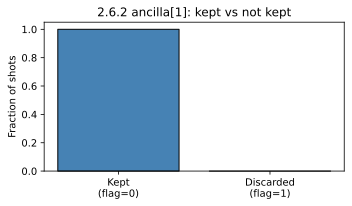

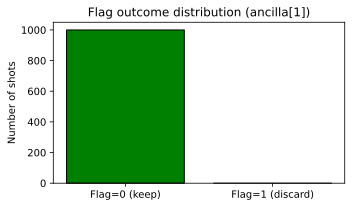

  ancilla[2]:  Kept: 1000  |  Discarded: 0  |  Discard rate: 0.0000


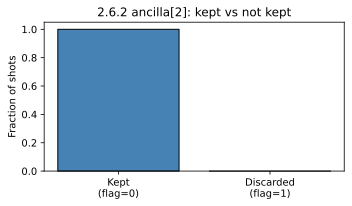

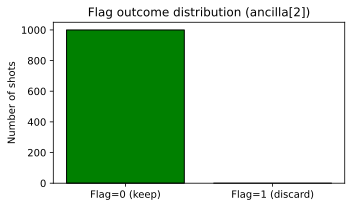

  ancilla[4]:  Kept: 1000  |  Discarded: 0  |  Discard rate: 0.0000


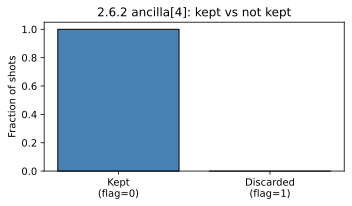

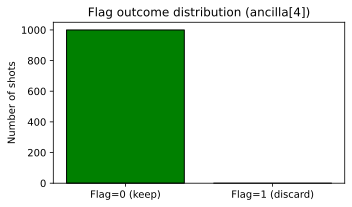

  ancilla[5]:  Kept: 1000  |  Discarded: 0  |  Discard rate: 0.0000


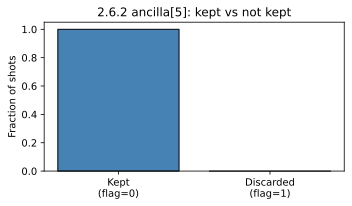

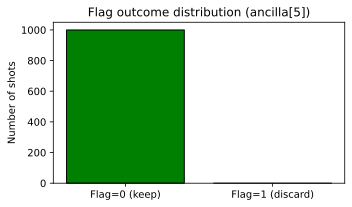

In [21]:
# Run A4 circuit (executiona4) with four ancilla flag qubits; two graphs per flag qubit
# Sample layout: 6 columns = ancilla[0]..ancilla[5]. Flag qubits = ancilla[1], [2], [4], [5] (columns 1, 2, 4, 5)
FLAG_SHOTS = 1000
FLAG_COLS = [1, 2, 4, 5]  # four ancilla flag qubits
cirq_run = emit_circuit(executiona4)
squin_run = load_circuit(cirq_run)
stim_circuit = bloqade.stim.Circuit(squin_run)
sampler = stim_circuit.compile_sampler()
samples_flags = np.array(sampler.sample(shots=FLAG_SHOTS))

# Overall: keep shot only when all four flag bits are 0
flag_bits = samples_flags[:, FLAG_COLS]
all_flags_zero = np.all(flag_bits == 0, axis=1)
n_kept_overall = np.sum(all_flags_zero)
n_discarded_overall = FLAG_SHOTS - n_kept_overall
discard_rate_overall = n_discarded_overall / FLAG_SHOTS
n_flags_triggered = np.sum(flag_bits, axis=1)

print("2.6.2 Flag behavior (four ancilla flag qubits): discard shot if any flag is triggered (measurement = 1).")
print(f"Shots: {FLAG_SHOTS}  |  Kept (all 4 flags=0): {n_kept_overall}  |  Discarded: {n_discarded_overall}  |  Discard rate: {discard_rate_overall:.4f}")

# Two graphs per flag qubit: (1) kept vs discarded for that flag, (2) flag outcome distribution
for col in FLAG_COLS:
    flag_col = samples_flags[:, col]
    n_kept = np.sum(flag_col == 0)
    n_discarded = FLAG_SHOTS - n_kept
    discard_rate = n_discarded / FLAG_SHOTS
    print(f"  ancilla[{col}]:  Kept: {n_kept}  |  Discarded: {n_discarded}  |  Discard rate: {discard_rate:.4f}")
    plot_kept_vs_discarded(n_kept, FLAG_SHOTS, title=f"2.6.2 ancilla[{col}]: kept vs not kept", kept_label="Kept\n(flag=0)", discarded_label="Discarded\n(flag=1)")
    plot_flag_outcome_binary(n_kept, n_discarded, title=f"Flag outcome distribution (ancilla[{col}])")


### 4.2 Error Codes Implementation
Now that we have our circuit, let's implement our error code correction algorithm. We first implement our error code table functions.

In [32]:
import cirq

@squin.kernel
def apply_recovery_from_3bit_syndrome(
    data: ilist.IList[Qubit, Literal[7]],
    s1: int, s2: int, s3: int,
    recovery_pauli: int,  # 0 -> apply X_i, 1 -> apply Z_i
):
    # Determine which qubit index (0..6) to correct.
    # -1 means "identity / do nothing".
    q_idx = -1

    if (s1 == 0) and (s2 == 1) and (s3 == 1):
        q_idx = 0
    elif (s1 == 1) and (s2 == 1) and (s3 == 0):
        q_idx = 1
    elif (s1 == 0) and (s2 == 1) and (s3 == 0):
        q_idx = 2
    elif (s1 == 1) and (s2 == 0) and (s3 == 1):
        q_idx = 3
    elif (s1 == 0) and (s2 == 0) and (s3 == 1):
        q_idx = 4
    elif (s1 == 1) and (s2 == 0) and (s3 == 0):
        q_idx = 5
    elif (s1 == 0) and (s2 == 0) and (s3 == 0):
        q_idx = 6
    # (s1,s2,s3) == (1,1,1) leaves q_idx = -1 → identity

    # Apply the gate only once, after control flow
    if q_idx != -1:
        if recovery_pauli == 0:
            squin.x(data[q_idx])
        else:
            squin.z(data[q_idx])

    # -----------------------------
# 0) Conventions helper
# -----------------------------
def measbit_to_pm(meas_bit: int, plus_is_meas0: bool = True) -> int:
    """
    Return your desired encoding: + -> 1, - -> 0.

    Most stabilizer readouts: meas=0 means +1 eigenvalue, meas=1 means -1 eigenvalue.
      If that's true, then:
        meas 0 -> + -> 1
        meas 1 -> - -> 0
      so pm = 1 - meas

    If instead your pipeline already returns + as 1 and - as 0, set plus_is_meas0=False.
    """
    meas_bit = int(meas_bit)
    if plus_is_meas0:
        return 1 - meas_bit
    else:
        return meas_bit


# -----------------------------
# 1) Extract syndromes from ancilla[0..5]
#    Your mapping:
#      Sx1=anc[0], Sz2=anc[1], Sz3=anc[2], Sz1=anc[3], Sx2=anc[4], Sx3=anc[5]
# -----------------------------
def decode_a4_syndromes_from_ancillas(
    anc_bits_raw: List[int],
    *,
    plus_is_meas0: bool = True,
) -> Tuple[Tuple[int,int,int], Tuple[int,int,int]]:
    """
    Returns:
      sz_syn = (Sz1,Sz2,Sz3) as bits with +->1, -->0
      sx_syn = (Sx1,Sx2,Sx3) as bits with +->1, -->0
    """
    if len(anc_bits_raw) != 6:
        raise ValueError("Expected 6 ancilla bits in order anc[0..5].")

    # Convert each measured bit into +->1, -->0 encoding
    anc = [measbit_to_pm(b, plus_is_meas0=plus_is_meas0) for b in anc_bits_raw]

    sx1 = anc[0]
    sz2 = anc[1]
    sz3 = anc[2]
    sz1 = anc[3]
    sx2 = anc[4]
    sx3 = anc[5]

    sz_syn = (sz1, sz2, sz3)  # order matches table header Sz(1), Sz(2), Sz(3)
    sx_syn = (sx1, sx2, sx3)  # order matches Sx(1), Sx(2), Sx(3)
    return sz_syn, sx_syn


# -----------------------------
# 2) Pure-python mirror of your lookup (for printing which gate)
#    (matches the mapping inside apply_recovery_from_3bit_syndrome)
# -----------------------------
def syndrome_to_index(s1: int, s2: int, s3: int) -> int:
    """
    Returns data-qubit index in paper numbering (1..7),
    or 0 if identity (111).
    """
    if (s1, s2, s3) == (1,1,1): return 0
    if (s1, s2, s3) == (0,1,1): return 1
    if (s1, s2, s3) == (1,1,0): return 2
    if (s1, s2, s3) == (0,1,0): return 3
    if (s1, s2, s3) == (1,0,1): return 4
    if (s1, s2, s3) == (0,0,1): return 5
    if (s1, s2, s3) == (1,0,0): return 6
    if (s1, s2, s3) == (0,0,0): return 7
    # unknown pattern
    return -1


def format_corrections(sz_syn, sx_syn) -> List[str]:
    """
    According to your plan:
      Sz syndrome -> X correction
      Sx syndrome -> Z correction
    """
    x_i = syndrome_to_index(*sz_syn)
    z_i = syndrome_to_index(*sx_syn)

    out = []
    if x_i == 0:
        pass
    elif x_i > 0:
        out.append(f"X{x_i}")
    else:
        out.append("X?(invalid syndrome)")

    if z_i == 0:
        pass
    elif z_i > 0:
        out.append(f"Z{z_i}")
    else:
        out.append("Z?(invalid syndrome)")

    if not out:
        out = ["I"]
    return out


# -----------------------------
# 3) A kernel that *replays* prep and then applies your recovery kernel
#    using the decoded classical syndrome bits.
#    (This is NOT mid-circuit feedforward; it’s “run A4 -> decode -> run correction kernel”.)
# -----------------------------
@squin.kernel
def prepare_and_correct_a4(
    sz1: int, sz2: int, sz3: int,
    sx1: int, sx2: int, sx3: int,
):
    data = squin.qalloc(7)
    injection(data)

    # Apply X recovery from Z-syndrome
    apply_recovery_from_3bit_syndrome(data, sz1, sz2, sz3, 0)

    # Apply Z recovery from X-syndrome
    apply_recovery_from_3bit_syndrome(data, sx1, sx2, sx3, 1)

    # (Optionally measure data or continue circuit here)
    # e.g., measure all data to see effect
    for i in range(7):
        squin.broadcast.measure(data[i])


# -----------------------------
# 4) Backend execution: run executiona4(), get ancilla bits
#    This is the ONLY place you may need to adjust if your runner differs.
# -----------------------------
def run_and_get_ancilla_bits(shots: int = 1) -> np.ndarray:
    circ = emit_circuit(executiona4)

    simulator = cirq.Simulator()
    result = simulator.run(circ, repetitions=shots)

    # cirq stores measurements by key; squin names them automatically.
    # We grab them in insertion order.
    meas_dict = result.measurements  # dict: key -> array (shots, 1)

    # Stack all measurement columns
    cols = []
    for key in meas_dict:
        cols.append(meas_dict[key].flatten())

    samples = np.stack(cols, axis=1)  # shape (shots, num_meas)

    if samples.shape[1] != 6:
        raise RuntimeError(f"Expected 6 ancilla bits, got shape {samples.shape}")

    return samples

# -----------------------------
# 5) Main: run A4, decode, print corrections, then run correction kernel
# -----------------------------
def examine_a4_and_apply_corrections(shots: int = 10, *, plus_is_meas0: bool = True):
    anc_samples = run_and_get_ancilla_bits(shots=shots)

    for s in range(shots):
        anc_raw = anc_samples[s].tolist()

        sz_syn, sx_syn = decode_a4_syndromes_from_ancillas(
            anc_raw, plus_is_meas0=plus_is_meas0
        )
        corr = format_corrections(sz_syn, sx_syn)

        print(f"\nSHOT {s}")
        print(f"  raw ancilla bits (anc0..anc5) = {anc_raw}")
        print(f"  Sz syndrome (Sz1,Sz2,Sz3)     = {sz_syn}")
        print(f"  Sx syndrome (Sx1,Sx2,Sx3)     = {sx_syn}")
        print(f"  => corrections                = {' '.join(corr)}")

        # Now run a correction kernel using the decoded bits
        # Now run a correction kernel using the decoded bits (separate run)
        circ2 = emit_circuit(prepare_and_correct_a4, args=[*sz_syn, *sx_syn])
        sim2 = cirq.Simulator()
        res2 = sim2.run(circ2, repetitions=1)

        meas2 = res2.measurements
        cols2 = [meas2[k].flatten() for k in meas2]
        data_bits = np.stack(cols2, axis=1)[0].tolist()

        print(f"  (post-correction data meas)   = {data_bits}")


In [33]:
examine_a4_and_apply_corrections(shots=10, plus_is_meas0=True)



SHOT 0
  raw ancilla bits (anc0..anc5) = [0, 0, 0, 0, 0, 0]
  Sz syndrome (Sz1,Sz2,Sz3)     = (1, 1, 1)
  Sx syndrome (Sx1,Sx2,Sx3)     = (1, 1, 1)
  => corrections                = I
  (post-correction data meas)   = [1, 0, 1, 1, 0, 1, 0]

SHOT 1
  raw ancilla bits (anc0..anc5) = [0, 0, 0, 0, 0, 0]
  Sz syndrome (Sz1,Sz2,Sz3)     = (1, 1, 1)
  Sx syndrome (Sx1,Sx2,Sx3)     = (1, 1, 1)
  => corrections                = I
  (post-correction data meas)   = [0, 1, 1, 1, 1, 0, 0]

SHOT 2
  raw ancilla bits (anc0..anc5) = [0, 0, 0, 0, 0, 0]
  Sz syndrome (Sz1,Sz2,Sz3)     = (1, 1, 1)
  Sx syndrome (Sx1,Sx2,Sx3)     = (1, 1, 1)
  => corrections                = I
  (post-correction data meas)   = [1, 0, 1, 1, 0, 1, 0]

SHOT 3
  raw ancilla bits (anc0..anc5) = [0, 0, 0, 0, 0, 0]
  Sz syndrome (Sz1,Sz2,Sz3)     = (1, 1, 1)
  Sx syndrome (Sx1,Sx2,Sx3)     = (1, 1, 1)
  => corrections                = I
  (post-correction data meas)   = [1, 1, 0, 0, 1, 1, 0]

SHOT 4
  raw ancilla bits (anc0..an